<a href="https://colab.research.google.com/github/yesp2002/Time_Series_Analysis-using-LSTM/blob/main/Time_Series_Analysis_using_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
! pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.4 MB 35.1 MB/s 
     |████████████████████████████████| 62 kB 1.4 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [2]:
import yfinance as yf

In [ ]:
help(yf)

In [4]:
stock_symbol = 'GAIL.NS'

In [5]:
df = yf.download(stock_symbol,start = '2000-01-01',end = '2022-01-01')

[*********************100%***********************]  1 of 1 completed


In [6]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2008-12-01,3.41341,3.41341,3.41341,3.41341,3.346533,4453
2008-12-02,3.41341,3.41341,3.41341,3.41341,3.346533,695
2008-12-03,3.41341,3.41341,3.41341,3.41341,3.346533,0
2008-12-04,3.41341,3.41341,3.41341,3.41341,3.346533,556
2008-12-05,3.41341,3.41341,3.41341,3.41341,3.346533,0


In [7]:
df.shape

(3225, 6)

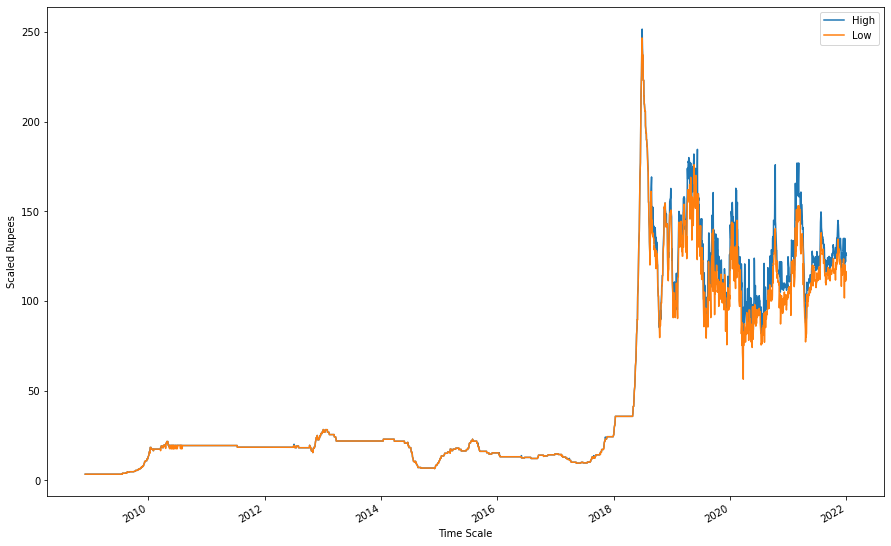

In [8]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt

plt.figure(figsize = (15,10))
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocater(interval = 60))
# x_dates = [dt.datetime.strftime(d,'%Y-%m-%d').date() for d in df.index.values]
x_dates = df.index.values
plt.plot(x_dates,df["High"], label = "High")
plt.plot(x_dates,df["Low"], label = "Low")
plt.xlabel('Time Scale')
plt.ylabel("Scaled Rupees")
plt.legend()
plt.gcf().autofmt_xdate()
plt.show()



In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import train_test_split, TimeSeriesSplit




### Data Preprocessing

In [10]:
target_y = df["Close"]
X_feat = df.iloc[:,0:3]

In [11]:
#Feature Scaling

sc = StandardScaler()
X_ft = sc.fit_transform(X_feat.values)
X_ft = pd.DataFrame(columns = X_feat.columns,data = X_ft, index = X_feat.index)

In [12]:
X_ft.head()

,Open,High,Low
Date,,,
2008-12-01,-0.852788,-0.847596,-0.861847
2008-12-02,-0.852788,-0.847596,-0.861847
2008-12-03,-0.852788,-0.847596,-0.861847
2008-12-04,-0.852788,-0.847596,-0.861847
2008-12-05,-0.852788,-0.847596,-0.861847


In [13]:
def lstm_split(data, n_steps):
  X,y = [],[]
  for i in range(len(data) - n_steps + 1):
    X.append(data.iloc[i:i+n_steps, :-1])
    y.append(data.iloc[i+n_steps - 1,-1])

  return np.array(X), np.array(y)

### Train and Test Splits 

In [14]:
stock_data = X_ft.copy()
stock_data['Target'] = target_y


X1,y1 = lstm_split(stock_data, n_steps = 2)

train_split = 0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = stock_data.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]

X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

print(X1.shape, X_train.shape, X_test.shape, y_test.shape)


(3224, 2, 3) (2580, 2, 3) (644, 2, 3) (644,)


In [15]:
X_train

array([[[-0.8527881 , -0.84759638, -0.86184698],
        [-0.8527881 , -0.84759638, -0.86184698]],

       [[-0.8527881 , -0.84759638, -0.86184698],
        [-0.8527881 , -0.84759638, -0.86184698]],

       [[-0.8527881 , -0.84759638, -0.86184698],
        [-0.8527881 , -0.84759638, -0.86184698]],

       ...,

       [[ 2.37484575,  2.27143139,  2.5085629 ],
        [ 2.37484575,  2.27143139,  2.5085629 ]],

       [[ 2.37484575,  2.27143139,  2.5085629 ],
        [ 2.37484575,  2.27143139,  2.5085629 ]],

       [[ 2.37484575,  2.27143139,  2.5085629 ],
        [ 2.37484575,  2.27143139,  2.5085629 ]]])

In [16]:
X_train.shape

(2580, 2, 3)

In [17]:
y_train

array([  3.41340995,   3.41340995,   3.41340995, ..., 165.5       ,
       165.5       , 165.5       ])

In [18]:
X_test

array([[[2.37484575, 2.27143139, 2.5085629 ],
        [2.18766346, 2.35706256, 2.2611158 ]],

       [[2.18766346, 2.35706256, 2.2611158 ],
        [2.5321585 , 2.43499665, 2.22160723]],

       [[2.5321585 , 2.43499665, 2.22160723],
        [2.52419341, 2.41575368, 2.60213538]],

       ...,

       [[1.52455976, 1.45071859, 1.46574955],
        [1.5056423 , 1.53057695, 1.4907023 ]],

       [[1.5056423 , 1.53057695, 1.4907023 ],
        [1.39014686, 1.50556103, 1.48030536]],

       [[1.39014686, 1.50556103, 1.48030536],
        [1.46780753, 1.50363676, 1.39609007]]])

In [19]:
y_test

array([160.25      , 163.25      , 170.        , 170.        ,
       154.5       , 154.75      , 153.19999695, 161.69999695,
       162.        , 149.8500061 , 157.80000305, 159.8500061 ,
       159.8500061 , 156.        , 146.94999695, 142.        ,
       153.8999939 , 135.5       , 135.5       , 139.8999939 ,
       142.8999939 , 142.        , 142.        , 126.        ,
       126.5       , 132.6000061 , 126.25      , 132.30000305,
       129.8999939 , 129.75      , 133.30000305, 122.59999847,
       122.59999847, 118.44999695, 112.        , 103.34999847,
       101.        , 101.        , 102.5       , 105.        ,
       105.        ,  94.80000305,  94.15000153,  95.        ,
        95.        ,  95.        ,  96.        ,  88.        ,
        92.        ,  92.        ,  92.        ,  92.        ,
       102.        , 101.94999695, 115.80000305, 115.55000305,
       123.84999847, 124.69999695, 120.        , 110.        ,
       102.34999847, 105.44999695, 112.59999847, 109.  

In [20]:
X_test_date.shape

(645,)

### Building the LSTM Model

In [21]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = False))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer = 'adam')
lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4,641
Trainable params: 4,641
Non-trainable params: 0
_________________________________________________________________


In [22]:
history = lstm.fit(X_train,y_train, epochs = 100, batch_size = 4, verbose = 2, shuffle = False)

Epoch 1/100
645/645 - 2s - loss: 1946.9291 - 2s/epoch - 4ms/step
Epoch 2/100
645/645 - 1s - loss: 178.1723 - 1s/epoch - 2ms/step
Epoch 3/100
645/645 - 1s - loss: 112.1258 - 1s/epoch - 2ms/step
Epoch 4/100
645/645 - 1s - loss: 77.1872 - 1s/epoch - 2ms/step
Epoch 5/100
645/645 - 1s - loss: 45.9733 - 1s/epoch - 2ms/step
Epoch 6/100
645/645 - 1s - loss: 23.0136 - 1s/epoch - 2ms/step
Epoch 7/100
645/645 - 1s - loss: 10.8147 - 1s/epoch - 2ms/step
Epoch 8/100
645/645 - 1s - loss: 6.3434 - 1s/epoch - 2ms/step
Epoch 9/100
645/645 - 2s - loss: 5.0387 - 2s/epoch - 3ms/step
Epoch 10/100
645/645 - 2s - loss: 4.9977 - 2s/epoch - 3ms/step
Epoch 11/100
645/645 - 2s - loss: 5.2182 - 2s/epoch - 3ms/step
Epoch 12/100
645/645 - 2s - loss: 5.5381 - 2s/epoch - 3ms/step
Epoch 13/100
645/645 - 2s - loss: 5.5005 - 2s/epoch - 3ms/step
Epoch 14/100
645/645 - 2s - loss: 5.5797 - 2s/epoch - 3ms/step
Epoch 15/100
645/645 - 2s - loss: 5.9848 - 2s/epoch - 3ms/step
Epoch 16/100
645/645 - 3s - loss: 6.0866 - 3s/epoch -

In [23]:
y_pred = lstm.predict(X_test)


rmse = mean_squared_error(y_test,y_pred, squared = False)
mape = mean_absolute_percentage_error(y_test,y_pred[:,0])

print("RMSE : ",rmse)
print("MAPE : ",mape)

RMSE :  4.716613807056373
MAPE :  0.02992934560560693


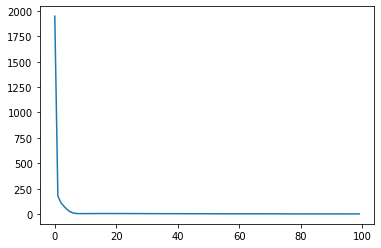

In [24]:
#We see that within 20 epochs the model trained very well and loss decreased significantly
loss = history.history['loss']
plt.plot(loss)

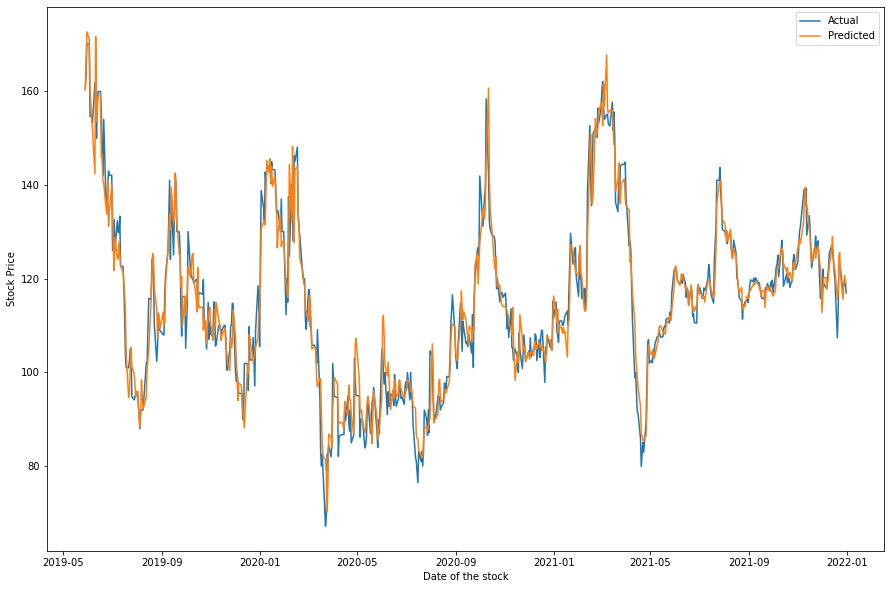

In [25]:
plt.figure(figsize = (15,10))

plt.plot(X_test_date[1:],y_test, label = 'Actual')
plt.plot(X_test_date[1:],y_pred, label = 'Predicted')
plt.xlabel("Date of the stock")
plt.ylabel("Stock Price")
plt.legend()
plt.show()

### Building a deeper LSTM Model

In [26]:
lstm = Sequential()
lstm.add(LSTM(50, input_shape = (X_train.shape[1],X_train.shape[2]), activation = 'relu', return_sequences = True))
lstm.add(LSTM(50, activation = 'relu'))
lstm.add(Dense(1))

lstm.compile(loss='mean_squared_error', optimizer = 'adam')
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 2, 50)             10800     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 31,051
Trainable params: 31,051
Non-trainable params: 0
_________________________________________________________________


In [27]:
history = lstm.fit(X_train,y_train, epochs = 100, batch_size = 4, verbose = 2, shuffle = False)

Epoch 1/100
645/645 - 3s - loss: 905.6180 - 3s/epoch - 5ms/step
Epoch 2/100
645/645 - 2s - loss: 371.9358 - 2s/epoch - 3ms/step
Epoch 3/100
645/645 - 2s - loss: 130.8478 - 2s/epoch - 3ms/step
Epoch 4/100
645/645 - 2s - loss: 85.0010 - 2s/epoch - 3ms/step
Epoch 5/100
645/645 - 2s - loss: 48.0142 - 2s/epoch - 2ms/step
Epoch 6/100
645/645 - 2s - loss: 21.6137 - 2s/epoch - 2ms/step
Epoch 7/100
645/645 - 2s - loss: 11.4467 - 2s/epoch - 3ms/step
Epoch 8/100
645/645 - 2s - loss: 7.4877 - 2s/epoch - 3ms/step
Epoch 9/100
645/645 - 2s - loss: 5.9719 - 2s/epoch - 2ms/step
Epoch 10/100
645/645 - 2s - loss: 5.5680 - 2s/epoch - 2ms/step
Epoch 11/100
645/645 - 2s - loss: 5.5806 - 2s/epoch - 3ms/step
Epoch 12/100
645/645 - 2s - loss: 5.8394 - 2s/epoch - 2ms/step
Epoch 13/100
645/645 - 2s - loss: 5.9948 - 2s/epoch - 2ms/step
Epoch 14/100
645/645 - 2s - loss: 5.8429 - 2s/epoch - 2ms/step
Epoch 15/100
645/645 - 2s - loss: 5.6499 - 2s/epoch - 3ms/step
Epoch 16/100
645/645 - 2s - loss: 5.5778 - 2s/epoch - 

In [28]:
y_pred = lstm.predict(X_test)


rmse = mean_squared_error(y_test,y_pred, squared = False)
mape = mean_absolute_percentage_error(y_test,y_pred[:,0])

print("RMSE : ",rmse)
print("MAPE : ",mape)

RMSE :  4.863124410913745
MAPE :  0.03073378351811598


#### We see that as the model became more complex with more layers, the model overfit, which caused the model to not perform as well as previous simple model.

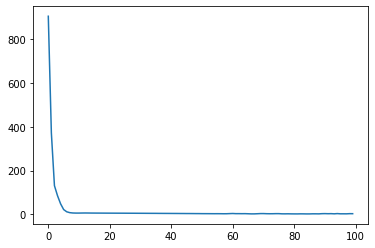

In [29]:
#We see that within 15 epochs the model trained very well and loss decreased significantly
loss = history.history['loss']
plt.plot(loss)

### Now increasing the n_steps value to 10 and training the model

In [30]:
stock_data = X_ft.copy()
stock_data['Target'] = target_y


X1,y1 = lstm_split(stock_data, n_steps = 10)

train_split = 0.8
split_idx = int(np.ceil(len(X1)*train_split))
date_index = stock_data.index

X_train, X_test = X1[:split_idx], X1[split_idx:]
y_train, y_test = y1[:split_idx], y1[split_idx:]

X_train_date, X_test_date = date_index[:split_idx], date_index[split_idx:]

print(X1.shape, X_train.shape, X_test.shape, y_test.shape)

(3216, 10, 3) (2573, 10, 3) (643, 10, 3) (643,)


In [31]:
lstm = Sequential()
lstm.add(LSTM(32, input_shape = (X_train.shape[1], X_train.shape[2]), activation = 'relu', return_sequences = True))
lstm.add(LSTM(16,activation = 'relu'))
lstm.add(Dense(1))
lstm.compile(loss='mean_squared_error', optimizer = 'adam')
lstm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 10, 32)            4608      
                                                                 
 lstm_4 (LSTM)               (None, 16)                3136      
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 7,761
Trainable params: 7,761
Non-trainable params: 0
_________________________________________________________________


In [32]:
history = lstm.fit(X_train,y_train, epochs = 100, batch_size = 4, verbose = 2, shuffle = False)

Epoch 1/100
644/644 - 7s - loss: 666.1385 - 7s/epoch - 11ms/step
Epoch 2/100
644/644 - 5s - loss: 2524.6177 - 5s/epoch - 8ms/step
Epoch 3/100
644/644 - 5s - loss: 317.2137 - 5s/epoch - 8ms/step
Epoch 4/100
644/644 - 5s - loss: 141.5036 - 5s/epoch - 8ms/step
Epoch 5/100
644/644 - 5s - loss: 98.6214 - 5s/epoch - 8ms/step
Epoch 6/100
644/644 - 5s - loss: 88.2657 - 5s/epoch - 8ms/step
Epoch 7/100
644/644 - 5s - loss: 84.1101 - 5s/epoch - 8ms/step
Epoch 8/100
644/644 - 6s - loss: 90.6386 - 6s/epoch - 9ms/step
Epoch 9/100
644/644 - 7s - loss: 89.5116 - 7s/epoch - 11ms/step
Epoch 10/100
644/644 - 5s - loss: 90.7215 - 5s/epoch - 8ms/step
Epoch 11/100
644/644 - 5s - loss: 91.6320 - 5s/epoch - 8ms/step
Epoch 12/100
644/644 - 5s - loss: 96.4242 - 5s/epoch - 8ms/step
Epoch 13/100
644/644 - 5s - loss: 92.2624 - 5s/epoch - 8ms/step
Epoch 14/100
644/644 - 5s - loss: 95.0655 - 5s/epoch - 8ms/step
Epoch 15/100
644/644 - 5s - loss: 64.8293 - 5s/epoch - 8ms/step
Epoch 16/100
644/644 - 5s - loss: 103.3685

In [33]:
y_pred = lstm.predict(X_test)


rmse = mean_squared_error(y_test,y_pred, squared = False)
mape = mean_absolute_percentage_error(y_test,y_pred[:,0])

print("RMSE : ",rmse)
print("MAPE : ",mape)

RMSE :  15.073647393844716
MAPE :  0.1281274928137724


### Simple Moving Average (SMA)

In [34]:
train_split = 0.8
split_idx = int(np.ceil(len(stock_data)*train_split))
train = stock_data[['Open']].iloc[:split_idx]
test = stock_data[['Open']].iloc[split_idx:]

test_pred = np.array([train.rolling(10).mean().iloc[-1]]*len(test)).reshape((-1,1))

print("Test RMSE: %.3f" % mean_squared_error(test,test_pred))
print("Test MAPE: %.3f" % mean_absolute_percentage_error(test,test_pred))

# plt.figure(figsize = ( 15,10))
# plt.plot(test , label = "Actual") 
# plt.plot(test_pred, label = "Predicted") 
# plt.legend()
# plt.show()



Test RMSE: 1.063
Test MAPE: 0.853


In [35]:
test_pred.shape

(645, 1)

In [36]:
test.shape

(645, 1)